# Neural Networks Fundamentals - PyTorch Convolutional Neural Network
This project was part of the (cannot excplicitly name it) course at TU Eindhoven. It focuses on the fundamentals of neural networks, with an emphasis on implementing a Multi-Layer Perceptron (MLP) to classify digits from the MNIST dataset. You will work with fully-connected layers, activation functions (ReLU and Sigmoid), and mini-batch SGD with cross-entropy loss. The project also involves analyzing the model’s performance, calculating trainable parameters, and experimenting with different loss functions such as Cross-Entropy, Dice, and Focal Loss to enhance accuracy.

### Running Code
Using course provided "experiments" environment is recommended.

### Results

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [2]:
DEBUG = True # Used to display additional information during program execution
TEST_SIZE = 1000
VALIDATION_SIZE = 1000

BATCHSIZE = 256
WORKERS = 8

EPOCHS = 10
LEARNING_RATE = 0.001
TRAININIG_UPDATES = 1 # number of epochs after which trainiing update is printed
TRAINING_SHOW_UPDATES = 1 # number of epoch after which trainiing plot is shown


n = 785
m = 70000
labels_train.shape = (68000,)
values_train.shape = (784, 68000)
labels_test.shape = (1000,)
values_test.shape = (784, 1000)


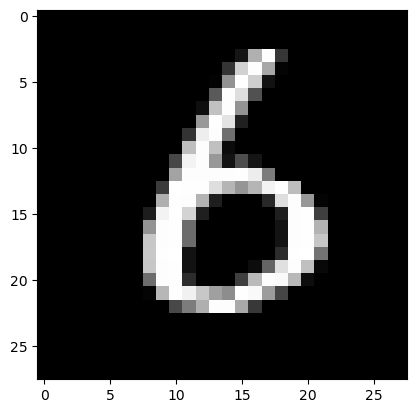

Label: 6


In [3]:
# Load dataset from a file
data = pd.read_csv('Datasets/MNIST_CSV/mnist.csv', header=None)
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

# Split data into test, validation, and training sets
data_test = data[0:TEST_SIZE].T
labels_test = data_test[0]
values_test = data_test[1:n].astype(np.float32) / 255.0 # converted and normalized

data_validation = data[TEST_SIZE:(TEST_SIZE+VALIDATION_SIZE)].T
labels_validation = data_validation[0]
values_validation = data_validation[1:n].astype(np.float32) / 255.0 # converted and normalized

data_train = data[(TEST_SIZE+VALIDATION_SIZE):m].T
labels_train = data_train[0]
values_train = data_train[1:n].astype(np.float32) / 255.0   # converted and normalized

def show_image(values, index):
    """
    Display image in np format.
    """
    image = values[:, index, None]
    image = image.reshape((28,28)) * 255
    plt.gray()
    plt.imshow(image)
    plt.show()

if DEBUG:
    print("n =", n)
    print("m =", m)
    print("labels_train.shape =", labels_train.shape)
    print("values_train.shape =", values_train.shape)
    print("labels_test.shape =", labels_test.shape)
    print("values_test.shape =", values_test.shape)
    show_image(values_train, 0)
    print("Label:", labels_train[0])


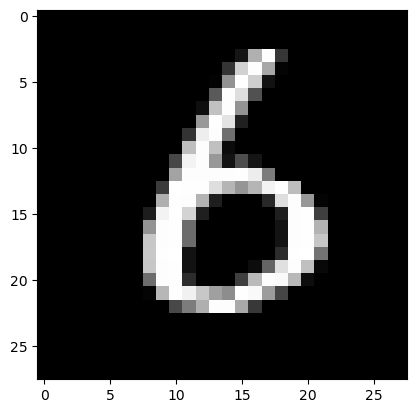

Label: 6


In [4]:
# Convert to PyTorch tensors
values_train = torch.tensor(values_train.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_train = torch.tensor(labels_train, dtype=torch.long)
dataset_train = TensorDataset(values_train, labels_train)
loader_train = DataLoader(dataset_train, 
                          batch_size=BATCHSIZE, 
                          shuffle=True, 
                          num_workers=WORKERS)

values_validation = torch.tensor(values_validation.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_validation = torch.tensor(labels_validation, dtype=torch.long)
dataset_validation = TensorDataset(values_validation, labels_validation)
loader_validation = DataLoader(dataset_validation, 
                               batch_size=BATCHSIZE, 
                               shuffle=False, 
                               num_workers=WORKERS)

values_test = torch.tensor(values_test.T, dtype=torch.float32).view(-1, 1, 28, 28)
labels_test = torch.tensor(labels_test, dtype=torch.long)
dataset_test = TensorDataset(values_test, labels_test)
loader_test = DataLoader(dataset_test, 
                         batch_size=BATCHSIZE, 
                         shuffle=False, 
                         num_workers=WORKERS)

if DEBUG:
    # show image after np -> tensor conversion
    sample_idx = 0
    plt.imshow(values_train[sample_idx].squeeze(), cmap="gray")
    plt.show()
    print("Label:", labels_train[sample_idx].item())

In [5]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 → ReLU → MaxPool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 → ReLU → MaxPool
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = self.relu(self.fc1(x))  # Fully Connected → ReLU
        x = self.softmax(self.fc2(x))  # Fully Connected → LogSoftmax
        return x
    

Epoch [1/10], Loss: 0.124


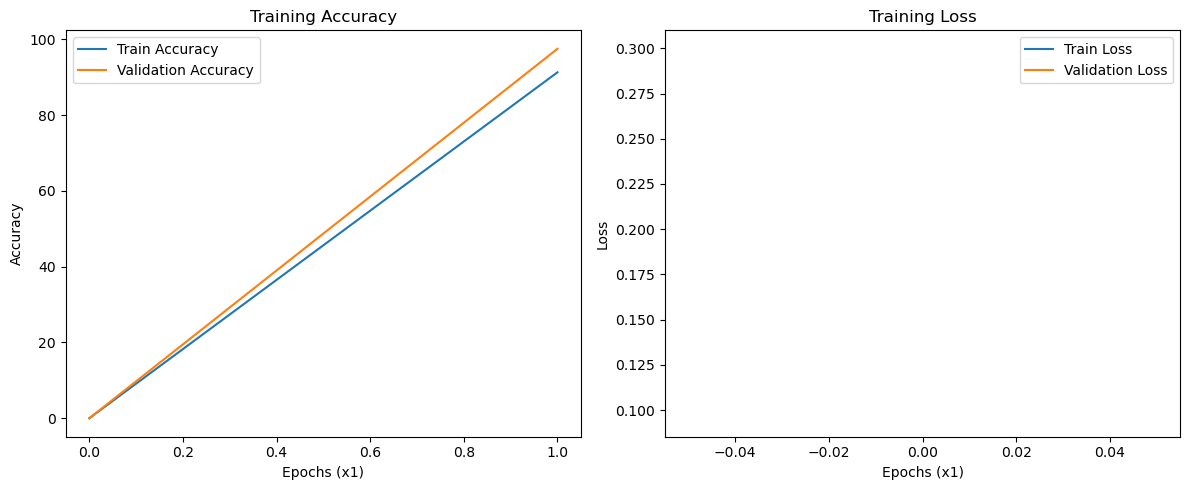

Epoch [2/10], Loss: 0.092


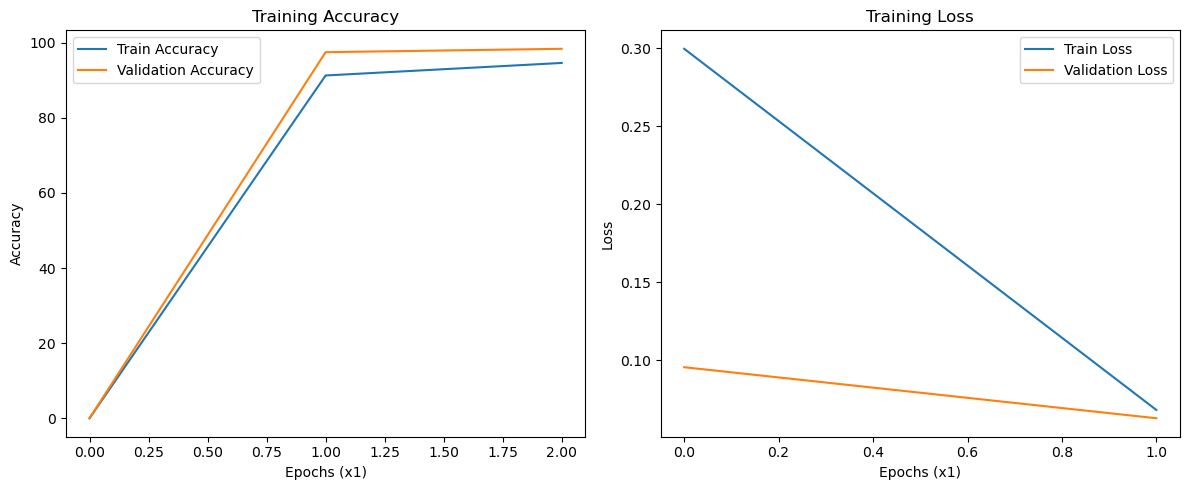

Epoch [3/10], Loss: 0.088


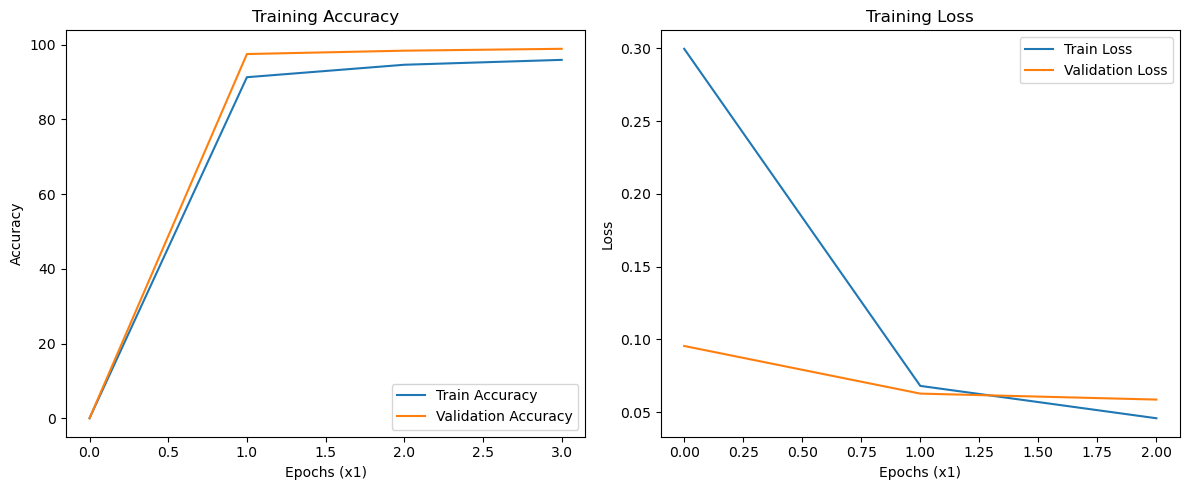

Epoch [4/10], Loss: 0.083


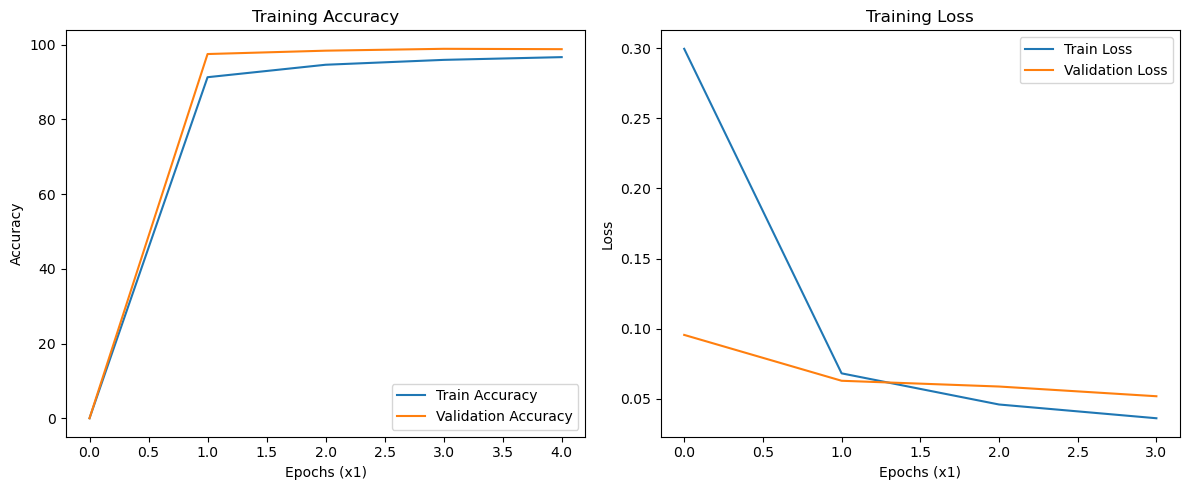

Epoch [5/10], Loss: 0.098


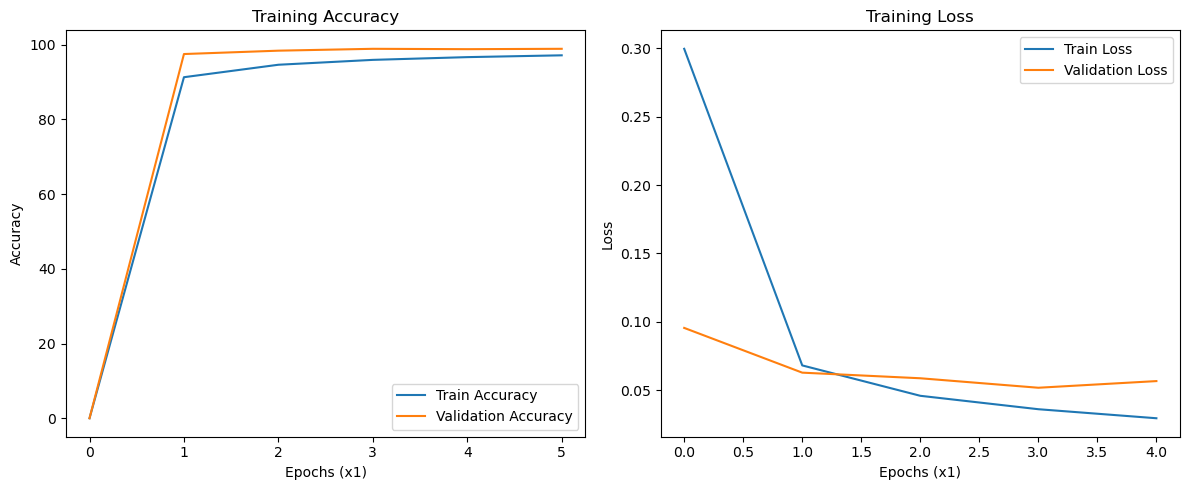

Epoch [6/10], Loss: 0.073


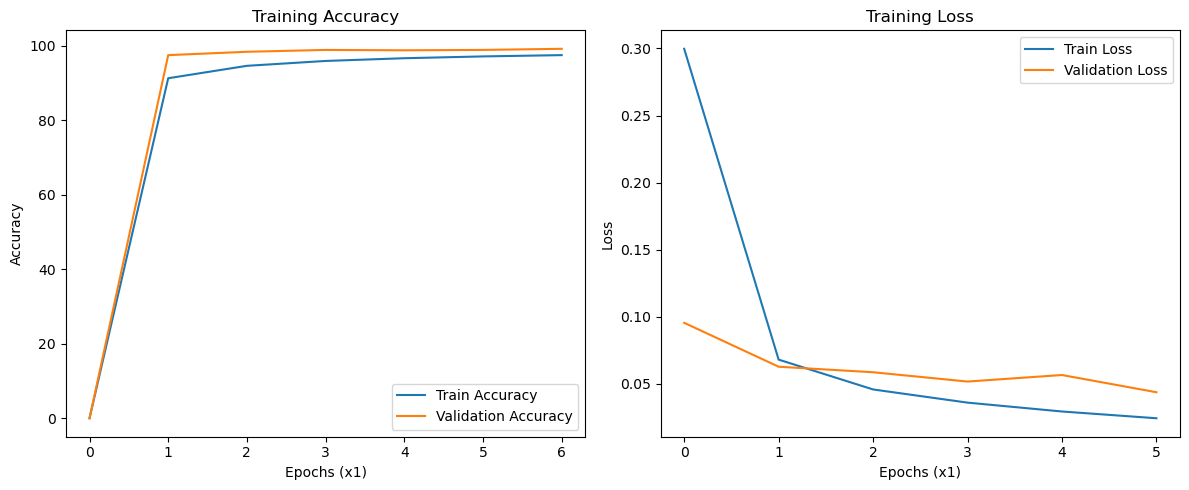

Epoch [7/10], Loss: 0.074


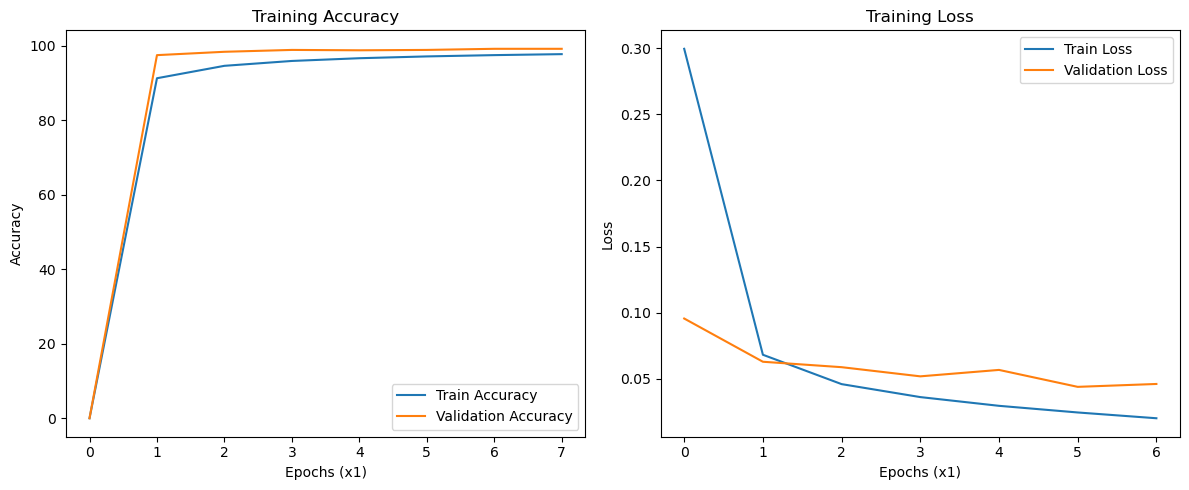

Epoch [8/10], Loss: 0.078


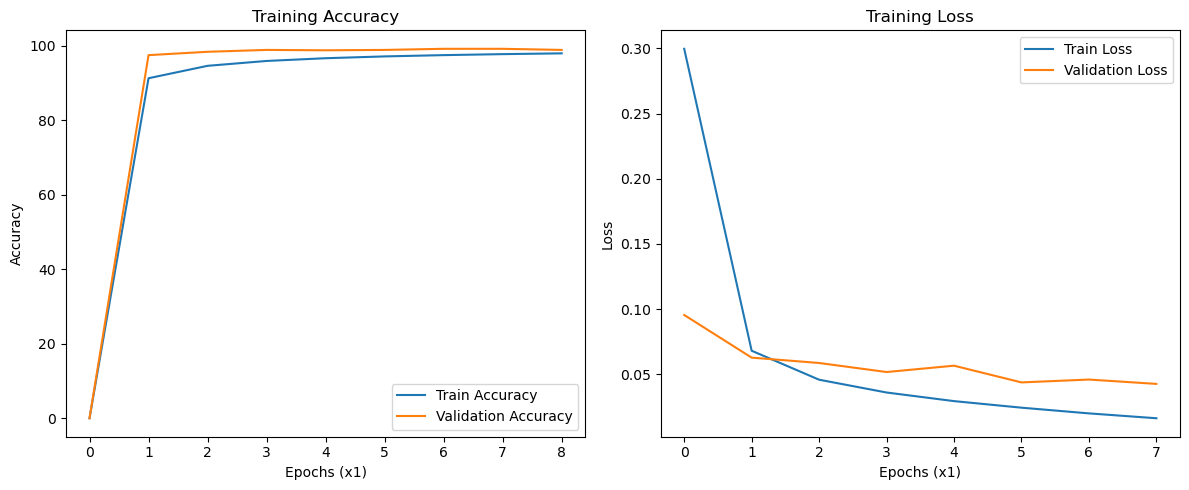

Epoch [9/10], Loss: 0.076


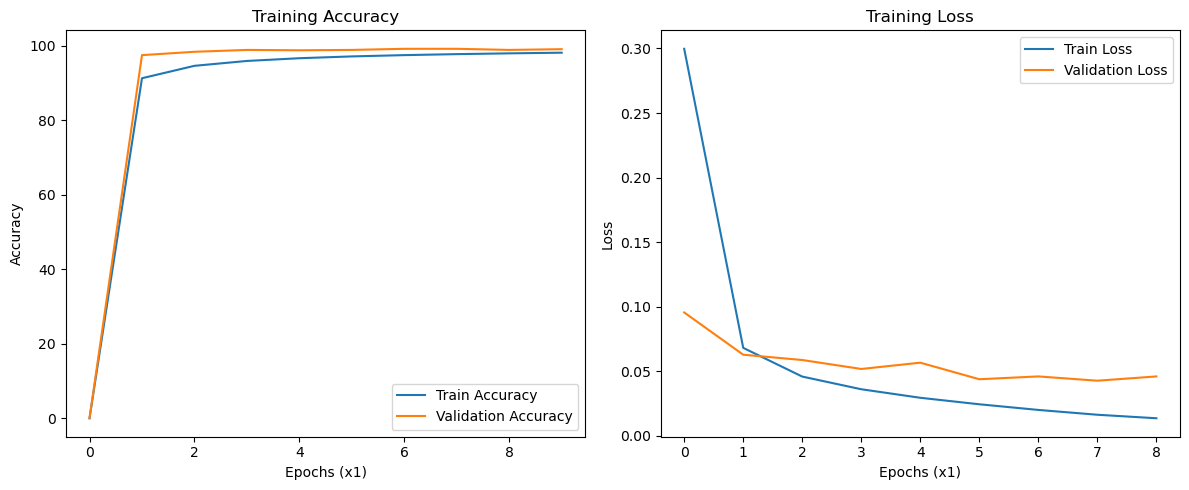

Epoch [10/10], Loss: 0.058


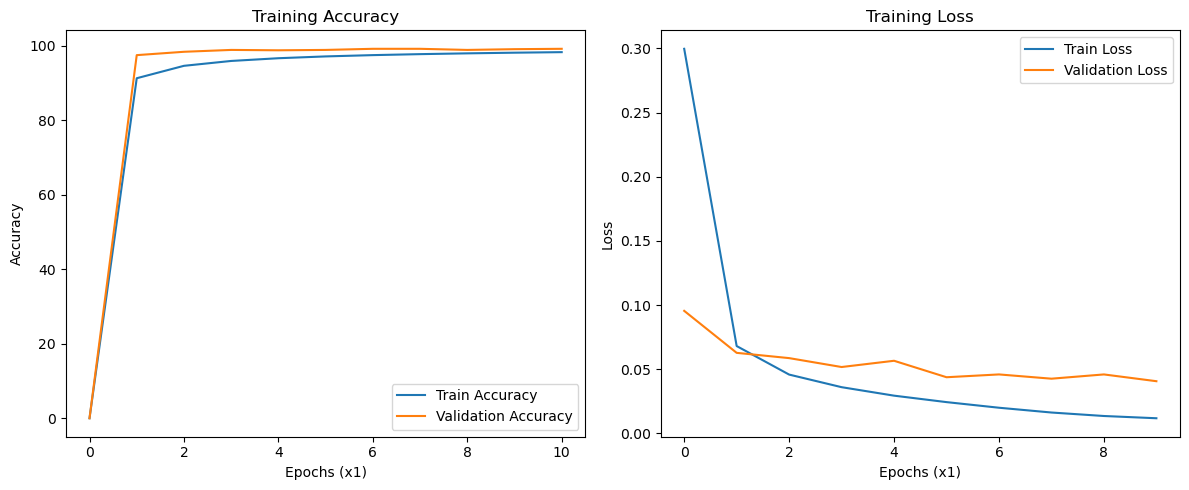

In [6]:
# Training setup

# Prefer CUDA > Metal > CPU
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_train_history = []
accuracy_train_history = [0]

loss_validation_history = []
accuracy_validation_history = [0]

start_time = time.time()

correct_train = 0
total_train = 0

# Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(loader_train):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    loss_train_history.append(running_loss / len(loader_train))
    accuracy_train_history.append(100 * correct_train / total_train)

    # Validation loop with accuracy calculation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in loader_validation:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    loss_validation_history.append(val_loss / len(loader_validation))
    accuracy_validation_history.append(100 * correct_val / total_val)

    if i % TRAINING_SHOW_UPDATES == 0:
        print(f"Epoch [{epoch}/{EPOCHS}], Loss: {loss.item():.3f}")
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

        ax[0].plot(accuracy_train_history, label="Train Accuracy")
        ax[0].plot(accuracy_validation_history, label="Validation Accuracy")
        ax[0].set_title("Training Accuracy")
        ax[0].set_xlabel(f"Epochs (x{TRAININIG_UPDATES})")
        ax[0].set_ylabel("Accuracy")
        ax[0].legend()

        ax[1].plot(loss_train_history, label="Train Loss")
        ax[1].plot(loss_validation_history, label="Validation Loss")
        ax[1].set_title("Training Loss")
        ax[1].set_xlabel(f"Epochs (x{TRAININIG_UPDATES})")
        ax[1].set_ylabel("Loss")
        ax[1].legend()

        plt.tight_layout()
        plt.show()

end_time = time.time()
training_time = end_time - start_time

In [7]:
# Evaluate model
def evaluate(loader):
    """Evaluate model performance"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train_acc = evaluate(loader_train)
val_acc = evaluate(loader_validation)
test_acc = evaluate(loader_test)

print(f"Training Time: {training_time:.2f} seconds")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


Training Time: 233.29 seconds
Train Accuracy: 0.998
Validation Accuracy: 0.992
Test Accuracy: 0.995
